### 1. Import and data loading

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,RatingDiff,AvgRating,WhiteIsHigherRated,WhiteRatingAdvantage,WhiteElo_squared,BlackElo_squared,RatingDiff_squared,...,WhiteEloCat_2200-2300,WhiteEloCat_2300-2400,WhiteEloCat_2400-2500,WhiteEloCat_2500-2600,WhiteEloCat_2600+,BlackEloCat_2200-2300,BlackEloCat_2300-2400,BlackEloCat_2400-2500,BlackEloCat_2500-2600,BlackEloCat_2600+
0,2504,2371,2,133,2437.5,1,133,6270016,5621641,17689,...,0,0,0,1,0,0,1,0,0,0
1,2487,2596,1,109,2541.5,0,-109,6185169,6739216,11881,...,0,0,1,0,0,0,0,0,1,0
2,2915,2921,1,6,2918.0,0,-6,8497225,8532241,36,...,0,0,0,0,1,0,0,0,0,1
3,2542,2433,2,109,2487.5,1,109,6461764,5919489,11881,...,0,0,0,1,0,0,0,1,0,0
4,2473,2658,0,185,2565.5,0,-185,6115729,7064964,34225,...,0,0,1,0,0,0,0,0,0,1


### 2. Prepare data

In [3]:
X = df.drop('ResultNumeric', axis=1)
y = df['ResultNumeric']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (3266132, 43)
Target: (3266132,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y
)

### 4. Train model

In [5]:
xgb_base = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42,
    tree_method='hist',
    n_jobs=2
)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [6, 8],
    "learning_rate": [0.1, 0.2],
}

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='accuracy',
    cv=2,
    verbose=2,
    n_jobs=1
)

In [6]:
start_time = time.time()

grid_search.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"\n Tuning completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Show best parameters
print(f"Best CV accuracy: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")
print(f"\nBest parameters:")
for param, value in sorted(grid_search.best_params_.items()):
    print(f" {param}: {value}")

# Get best model
xgb_model = grid_search.best_estimator_

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  23.8s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  23.8s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=  42.7s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=  42.6s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=100; total time=  28.9s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=100; total time=  28.4s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=200; total time=  50.2s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=200; total time=  52.0s
[CV] END ...learning_rate=0.2, max_depth=6, n_estimators=100; total time=  22.6s
[CV] END ...learning_rate=0.2, max_depth=6, n_estimators=100; total time=  22.1s
[CV] END ...learning_rate=0.2, max_depth=6, n_estimators=200; total time=  40.2s
[CV] END ...learning_rate=0.2, max_depth=6, n_est

### 5. Evaluate

In [7]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Set Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Black Win', 'Draw', 'White Win']))


Test Set Accuracy: 0.5831 (58.31%)

Classification Report:

              precision    recall  f1-score   support

   Black Win       0.55      0.59      0.57    267660
        Draw       0.87      0.27      0.41     84135
   White Win       0.59      0.67      0.62    301432

    accuracy                           0.58    653227
   macro avg       0.67      0.51      0.53    653227
weighted avg       0.61      0.58      0.57    653227



### 6. Confusion Matrix

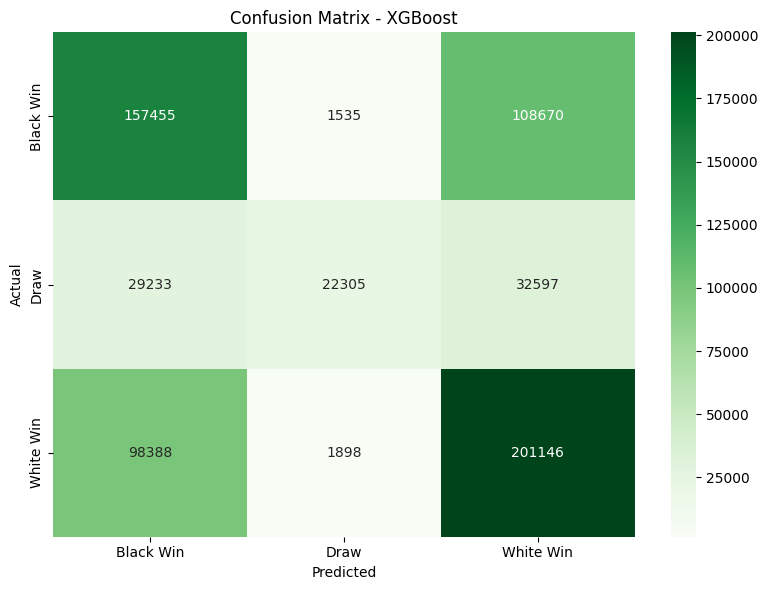

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Black Win', 'Draw', 'White Win'],
            yticklabels=['Black Win', 'Draw', 'White Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

### 7. Feature Importance

                  Feature  Importance
5    WhiteRatingAdvantage    0.350162
3               AvgRating    0.249645
31        Event_classical    0.099178
2              RatingDiff    0.070220
0                WhiteElo    0.061854
1                BlackElo    0.054960
42      BlackEloCat_2600+    0.016787
30            Event_blitz    0.011919
4      WhiteIsHigherRated    0.010662
29              ECO_Other    0.004877
13                ECO_A40    0.004713
16                ECO_B00    0.004384
9                 ECO_A00    0.004115
32            Event_rapid    0.004082
18                ECO_B06    0.004063
28                ECO_D02    0.003986
20                ECO_B12    0.003951
17                ECO_B01    0.003357
22                ECO_B23    0.002860
26                ECO_C00    0.002619
10                ECO_A01    0.002414
40  BlackEloCat_2400-2500    0.002198
37      WhiteEloCat_2600+    0.002185
25                ECO_B90    0.002163
35  WhiteEloCat_2400-2500    0.002044
15          

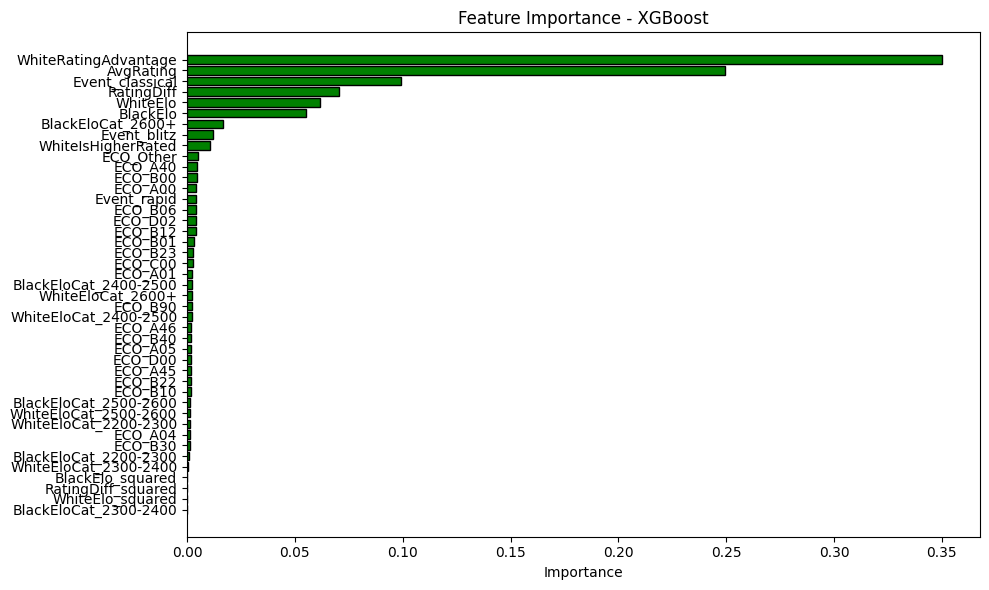

In [9]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()